In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../DXG Historical Data.csv')

In [3]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [4]:
tranformData(df)

In [5]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [6]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-12-01,12251.8,11949.3,12403.1,11919.0,8610000.0,0.0279
2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370
2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
...,...,...,...,...,...,...
2023-05-29,14600.0,14650.0,14750.0,14500.0,13240000.0,0.0104
2023-05-30,14950.0,14950.0,15200.0,14750.0,30200000.0,0.0240
2023-05-31,14900.0,14950.0,15200.0,14850.0,15100000.0,-0.0033


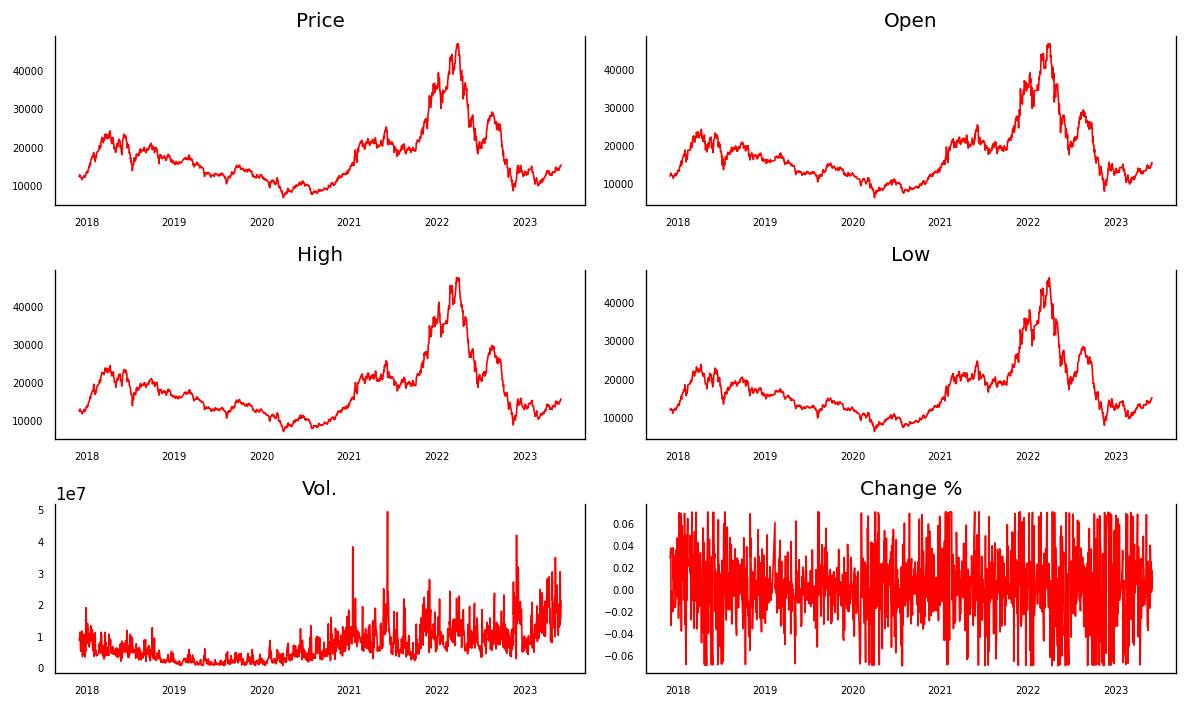

In [7]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [8]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Price_x,Open_x,High_x,Low_x,Vol._x,Change %_x
Price_y,1.0000,0.0002,0.0311,0.0128,0.0831,0.0015
Open_y,0.0000,1.0000,0.0000,0.0000,0.0100,0.0000
High_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
Low_y,0.0000,0.0000,0.0000,1.0000,0.0001,0.0000
Vol._y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0623
Change %_y,0.0747,0.0302,0.1042,0.0557,0.0472,1.0000


In [9]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  716.44    > 83.9383   =>   True
Open   ::  465.11    > 60.0627   =>   True
High   ::  244.72    > 40.1749   =>   True
Low    ::  91.55     > 24.2761   =>   True
Vol.   ::  27.65     > 12.3212   =>   True
Change % ::  0.41      > 4.1296    =>   False


In [10]:
nobs=int(0.2*len(df))
n_train = int(0.6 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(822, 6)
(274, 6)
(275, 6)


In [11]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [12]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.1296
 No. Lags Chosen       = 4
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.7031. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3692
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.5969. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

In [13]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [14]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Price"

 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.1336
 No. Lags Chosen       = 3
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8926
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.7397
 No. L

In [15]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [16]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.0797
 No. Lags Chosen       = 18
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.2936
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [17]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  68.30970054097375
BIC :  68.55114075040211
FPE :  4.640097327340555e+29
HQIC:  68.4023480669988 

Lag Order = 2
AIC :  66.69107800834512
BIC :  67.1398986223488
FPE :  9.195474516743642e+28
HQIC:  66.86331330434241 

Lag Order = 3
AIC :  65.7001829529732
BIC :  66.35678375690715
FPE :  3.413884100542806e+28
HQIC:  65.95216867251341 

Lag Order = 4
AIC :  65.02711519958282
BIC :  65.89189725012768
FPE :  1.741675690221515e+28
HQIC:  65.35901452619845 

Lag Order = 5
AIC :  64.65598620035378
BIC :  65.72935183110569
FPE :  1.2018041838892618e+28
HQIC:  65.06796284989872 

Lag Order = 6
AIC :  64.28039411743889
BIC :  65.56274694453049
FPE :  8.256268503028058e+27
HQIC:  64.77261234046121 

Lag Order = 7
AIC :  64.04048706000911
BIC :  65.53223198776229
FPE :  6.496622133592893e+27
HQIC:  64.61311164413728 

Lag Order = 8
AIC :  63.893625813052424
BIC :  65.59516903966268
FPE :  5.610889202189192e+27
HQIC:  64.54682208539501 

Lag Order = 9
AIC :  63.76094146386414
BI

In [18]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,72.98,73.02,4.964e+31,73.00
1,68.34,68.58,4.773e+29,68.43
2,66.71,67.16,9.347e+28,66.88
3,65.70,66.37,3.429e+28,65.96
4,65.01,65.89,1.713e+28,65.35
5,64.64,65.73,1.186e+28,65.06
6,64.28,65.58,8.250e+27,64.78
7,64.04,65.55*,6.501e+27,64.62
8,63.90,65.62,5.649e+27,64.56
9,63.76,65.69,4.922e+27,64.50


In [19]:
model_fitted = model.fit(19)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Jun, 2023
Time:                     00:28:35
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    67.1522
Nobs:                     801.000    HQIC:                   64.6663
Log likelihood:          -31407.3    FPE:                2.60624e+27
AIC:                      63.1157    Det(Omega_mle):     1.16530e+27
--------------------------------------------------------------------
Results for equation Price
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.165031        15.277900           -0.011           0.991
L1.Price            -0.957242         0.144622           -6.619           0.000
L1.Open             -0.080231         0.105964           -0.757 

In [20]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

19


array([[-6.5210e+02, -8.6970e+02,  4.3480e+02, -1.7391e+03,  1.1210e+07,
         6.7000e-03],
       [ 4.3500e+01, -5.2160e+02, -1.3044e+03,  9.1300e+02, -3.3000e+05,
         3.1200e-02],
       [ 1.1739e+03, -8.2620e+02,  6.0870e+02,  1.3040e+02, -1.5620e+07,
         5.6500e-02],
       [-1.3050e+02,  2.7392e+03,  6.9570e+02,  1.3044e+03,  3.7700e+06,
        -6.4100e-02],
       [-9.5640e+02, -1.1305e+03, -2.6090e+02, -1.3913e+03,  7.6400e+06,
        -3.9500e-02],
       [ 8.2600e+02, -8.2600e+02, -2.6090e+02,  1.7380e+02,  3.0000e+05,
         8.6400e-02],
       [-7.8260e+02,  8.6950e+02,  8.7000e+01, -6.0860e+02, -2.5600e+06,
        -7.8800e-02],
       [ 3.0430e+02, -1.0435e+03, -6.5220e+02,  3.4780e+02, -1.6100e+06,
         5.3200e-02],
       [ 4.7830e+02,  1.4783e+03,  1.2174e+03,  1.1305e+03, -1.3700e+06,
         1.0000e-02],
       [ 8.2610e+02, -1.2174e+03,  4.7830e+02, -1.1305e+03,  8.7000e+06,
         1.7700e-02],
       [-3.9130e+02,  1.8261e+03, -4.3490e+02,  2.

In [21]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2021-03-23,508.345061,-752.630146,-664.853803,427.154139,-9.248410e+06,6.081468e-02
2021-03-24,-250.627546,473.950436,635.904179,37.269835,2.494037e+06,-3.327322e-02
2021-03-25,478.567034,-479.485732,-329.694370,-216.740789,5.344389e+06,3.366958e-02
2021-03-26,418.085522,802.381974,916.390379,696.143302,-5.100278e+06,-2.517635e-03
2021-03-29,-182.162024,361.934174,-286.788877,82.483654,1.033724e+06,-3.798719e-02
...,...,...,...,...,...,...
2022-04-20,-0.052093,-0.045578,-0.047925,-0.031232,-4.228337e+02,-3.432839e-07
2022-04-21,-0.054531,-0.044886,-0.048386,-0.031906,-4.240344e+02,-5.526052e-07
2022-04-22,-0.052030,-0.047005,-0.048334,-0.032216,-4.224106e+02,-3.067065e-07


In [22]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2022-04-27,508.345061,-752.630146,-664.853803,427.154139,-9.248410e+06,6.081468e-02
2022-04-28,-250.627546,473.950436,635.904179,37.269835,2.494037e+06,-3.327322e-02
2022-04-29,478.567034,-479.485732,-329.694370,-216.740789,5.344389e+06,3.366958e-02
2022-05-04,418.085522,802.381974,916.390379,696.143302,-5.100278e+06,-2.517635e-03
2022-05-05,-182.162024,361.934174,-286.788877,82.483654,1.033724e+06,-3.798719e-02
...,...,...,...,...,...,...
2023-05-29,-0.054531,-0.044886,-0.048386,-0.031906,-4.240344e+02,-5.526052e-07
2023-05-30,-0.052030,-0.047005,-0.048334,-0.032216,-4.224106e+02,-3.067065e-07
2023-05-31,-0.054364,-0.044172,-0.047993,-0.031532,-4.207558e+02,-5.369181e-07


In [23]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [24]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [25]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2022-04-27,21290.945061,21508.369854,21682.946197,21122.754139,8.701590e+06,-0.006085
2022-04-28,20896.462576,21403.690144,21653.996573,20978.478112,7.097218e+06,-0.015944
2022-04-29,20980.547125,20819.524702,21295.352579,20617.461296,1.083723e+07,0.007867
2022-05-04,21482.717196,21037.741233,21853.098964,20952.587783,9.476974e+06,0.029161
2022-05-05,21802.725243,21617.891939,22124.056472,21370.197924,9.150437e+06,0.012467
...,...,...,...,...,...,...
2023-05-29,35612.742995,35460.168873,37011.609611,39875.605366,-7.998061e+06,0.025455
2023-05-30,35658.521911,35506.512446,37061.732682,39941.032578,-8.117760e+06,0.025478
2023-05-31,35704.246462,35552.811846,37111.807760,40006.428258,-8.237880e+06,0.025500


In [26]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2021-03-23,21290.945061,21508.369854,21682.946197,21122.754139,8.701590e+06,-0.006085
2021-03-24,20896.462576,21403.690144,21653.996573,20978.478112,7.097218e+06,-0.015944
2021-03-25,20980.547125,20819.524702,21295.352579,20617.461296,1.083723e+07,0.007867
2021-03-26,21482.717196,21037.741233,21853.098964,20952.587783,9.476974e+06,0.029161
2021-03-29,21802.725243,21617.891939,22124.056472,21370.197924,9.150437e+06,0.012467
...,...,...,...,...,...,...
2022-04-20,35566.912050,35413.778296,36961.438205,39810.145938,-7.878784e+06,0.025433
2022-04-21,35612.742995,35460.168873,37011.609611,39875.605366,-7.998061e+06,0.025455
2022-04-22,35658.521911,35506.512446,37061.732682,39941.032578,-8.117760e+06,0.025478


In [27]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]


,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
0,21290.945061,21508.369854,21682.946197,21122.754139,8.701590e+06,-0.006085
1,20896.462576,21403.690144,21653.996573,20978.478112,7.097218e+06,-0.015944
2,20980.547125,20819.524702,21295.352579,20617.461296,1.083723e+07,0.007867
3,21482.717196,21037.741233,21853.098964,20952.587783,9.476974e+06,0.029161
4,21802.725243,21617.891939,22124.056472,21370.197924,9.150437e+06,0.012467
...,...,...,...,...,...,...
269,35566.912050,35413.778296,36961.438205,39810.145938,-7.878784e+06,0.025433
270,35612.742995,35460.168873,37011.609611,39875.605366,-7.998061e+06,0.025455
271,35658.521911,35506.512446,37061.732682,39941.032578,-8.117760e+06,0.025478
272,35704.246462,35552.811846,37111.807760,40006.428258,-8.237880e+06,0.025500


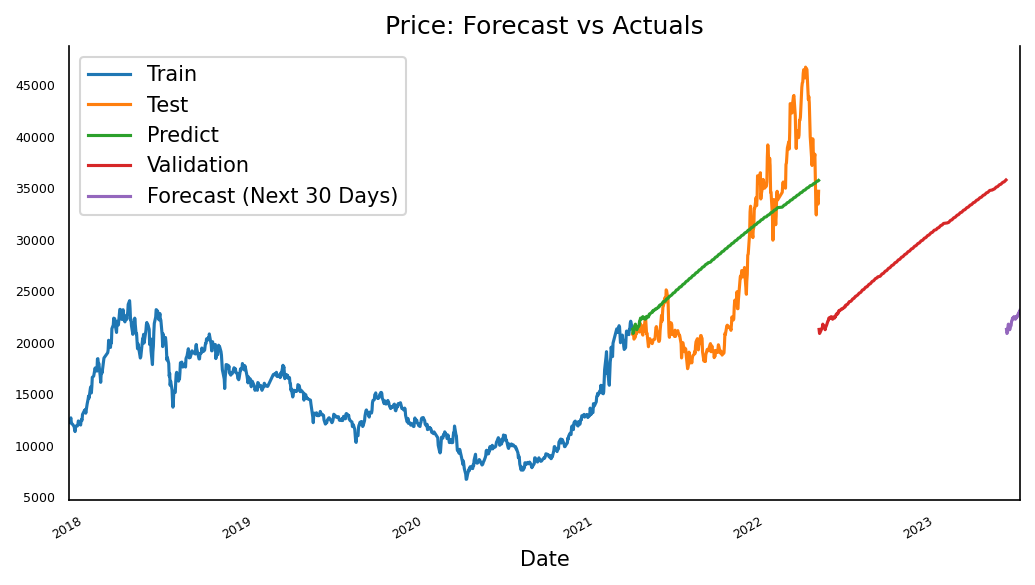

In [28]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, ax = plt.subplots(dpi=150, figsize=(7, 4))

# Chọn cột dữ liệu cần vẽ
col = 'Price'

# Vẽ dữ liệu huấn luyện
df_train[col].plot(legend=True, ax=ax, label='Train')

# Vẽ dữ liệu kiểm tra
df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')

# Vẽ dự đoán trên tập huấn luyện
df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)

# Vẽ dự đoán trên tập kiểm tra
df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)

# Vẽ dự đoán cho 30 ngày tiếp theo
df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')

# Định dạng đồ thị và tiêu đề
ax.set_title(col + ": Forecast vs Actuals")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)

plt.tight_layout()


In [29]:
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)  # Chuyển đổi dự đoán thành numpy array
    actual = np.array(actual)  # Chuyển đổi dữ liệu thực tế thành numpy array
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return {'mape': mape, 'rmse': rmse, }


print('Forecast Accuracy of: Price')
accuracy_prod = forecast_accuracy(df_results['Price_forecast'].values, df_test['Price'])
for k, v in accuracy_prod.items():
    print(str.title(k), ': ', round(v, 4))



Forecast Accuracy of: Price
Mape :  0.2026
Rmse :  5874.3375
